In [123]:
# Import necessary modules
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

# Import dataset
df = pd.read_parquet('data/transactions.parquet')

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759889 entries, 0 to 1759888
Data columns (total 12 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Shop                       int64  
 1   Order_Date_FK              int64  
 2   ProductCode                int64  
 3   OriginalSaleAmountInclVAT  float64
 4   CustomerID                 int64  
 5   SaleDocumentNumber         int64  
 6   Returned                   int64  
 7   RevenueInclVAT             float64
 8   CostPriceExclVAT           float64
 9   BrandName                  int64  
 10  ModelGroup                 int64  
 11  ProductGroup               int64  
dtypes: float64(3), int64(9)
memory usage: 161.1 MB


In [125]:
# Replace shop numbers 1-103 with 1 or 0 since shops with number >= 100 are online shops.
df['is_online_shop'] = df["Shop"].apply(lambda x : 1 if x >= 100 else 0)

# Drop unecessary columns as for now, maybe get them back afterwards
df.drop(columns=["Shop"], inplace=True)

In [126]:
cat_features = [
    'is_online_shop',
    'ProductCode',
    'CustomerID',
    'SaleDocumentNumber',
    'BrandName',
    'ModelGroup',
    'ProductGroup'
]

num_features = [
    'Order_Date_FK',
    'OriginalSaleAmountInclVAT',
    'Returned',
    'RevenueInclVAT',
    'CostPriceExclVAT'
]

In [127]:
# Split the dataset in X and y
X = df.drop(columns="Returned")
y = df["Returned"]

# Create X & y train/test variables
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12563, test_size=0.2)

In [128]:
"""
Extracts the year, month, and day from a date column in a pandas DataFrame.

Args:
    date_column (pandas.Series): A column of dates in the format 'YYYYMMDD'.

Returns:
    Tuple[List[str], List[str], List[str]]: Three lists containing the extracted year, month, and day values.
"""
def extract_date(date_column):
    year_list = []
    month_list = []
    day_list = []

    for full_date in date_column:
        full_date = str(full_date)
        year = full_date[0:4]
        month = full_date[4:6]
        day = full_date[6:8]
        year_list.append(year)
        month_list.append(month)
        day_list.append(day)

    return year_list, month_list, day_list

df['year'], df['month'], df['day'] = extract_date(df['Order_Date_FK'])

df.drop(columns=['Order_Date_FK'], inplace=True)

## Analysis

In [129]:
max_price = df['OriginalSaleAmountInclVAT'].max()

# Count the number of entries that have this maximum value
entries_at_max_price = df[df['OriginalSaleAmountInclVAT'] == max_price].shape[0]

print(entries_at_max_price)

7


In [130]:
# Group by month and count the number of returns
returns_by_price = df.groupby('OriginalSaleAmountInclVAT')['Returned'].sum()

# Find the month with the maximum returns
price_with_most_returns = returns_by_price.idxmax()

# Find the amount of returns
amount_of_returns_price = returns_by_price.max()

print(
    "Price with the most returns:", price_with_most_returns,
    "\nAmount of returns:", amount_of_returns_price)

Price with the most returns: 69.95 
Amount of returns: 6277


In [131]:
df['month'].value_counts()

month
07    782616
06    755597
08    221676
Name: count, dtype: int64

In [132]:
# Group by month and count the number of returns
returns_by_month = df.groupby('month')['Returned'].sum()

# Find the month with the maximum returns
month_with_most_returns = returns_by_month.idxmax()

# Find the amount of returns
amount_of_returns_month = returns_by_month.max()

print("Month with the most returns:", month_with_most_returns,
      "\nAmount of returns:", amount_of_returns_month)

Month with the most returns: 06 
Amount of returns: 33678


In [133]:
# Group by ProductCode and count the number of returns
returns_by_product = df.groupby(['ModelGroup'])['Returned'].sum()

# Group by ProductCode and count the number of returns
returns_by_product_month = df.groupby(['ModelGroup', 'month'])['Returned'].sum()

# Find the ProductCode with the maximum returns
product_with_most_returns = returns_by_product.idxmax()

# Find the amount of returns
amount_of_returns_product = returns_by_product.max()

# Find the product with the maximum returns per month
product_with_most_returns_month = returns_by_product_month.idxmax()

# Find the amount of returns per product and month
amount_of_returns_product_month = returns_by_product_month.max()

print("Month with the most returns:", product_with_most_returns,
      "\nAmount of returns:", amount_of_returns_product,
      "\n\nProduct with the most returns per Month:", product_with_most_returns_month,
      "\nTotal number of returns for this month and product:", amount_of_returns_product_month)

Month with the most returns: 3162564956579801398 
Amount of returns: 30586 

Product with the most returns per Month: (3162564956579801398, '06') 
Total number of returns for this month and product: 18752


In [134]:
df['Returned'].value_counts()

Returned
0    1692094
1      67795
Name: count, dtype: int64

In [135]:
# Group by ProductCode and count the number of returns
returns_by_shop = df.groupby(['is_online_shop', 'month'])['Returned'].sum()

# Find the ProductCode with the maximum returns
shop_with_most_returns = returns_by_shop.idxmax()

# Find the amount of returns
amount_of_returns_shop = returns_by_shop.max()

print("Month with the most returns:", shop_with_most_returns,
      "\nAmount of returns:", amount_of_returns_shop)

Month with the most returns: (0, '06') 
Amount of returns: 21849


In [136]:
df

,ProductCode,OriginalSaleAmountInclVAT,CustomerID,SaleDocumentNumber,Returned,RevenueInclVAT,CostPriceExclVAT,BrandName,ModelGroup,ProductGroup,is_online_shop,year,month,day
0,-1968361059464632550,99.95,-2190786785520839526,23995792,0,74.96,36.534515,3694837121284491212,3162564956579801398,-453682476182549203,0,2021,07,30
1,-1745497788861904687,21.95,-3499949798555834600,23995794,0,21.95,7.364523,-1657270726128381662,-6715310361529623819,-453682476182549203,0,2021,07,30
2,-4482110002029860032,69.95,-7841417233849937172,23995797,0,38.47,24.415000,-7202472198306336051,-248459121805647149,5294166889150293396,0,2021,07,30
3,-9146072753857637799,99.95,-7841417233849937172,23995797,0,54.97,32.293506,-2074012670196538378,-248459121805647149,5294166889150293396,0,2021,07,30
4,-8829485741699345914,49.95,7033964597104594686,23995798,0,17.48,8.885632,-4869459690934553786,-4124706989267335995,-453682476182549203,0,2021,07,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759884,-745373077535329727,120.00,-299104793296959079,23995789,0,78.00,38.390231,4614247681931237507,-4124706989267335995,-453682476182549203,0,2021,07,30
1759885,-2694142533085979238,8.50,-299104793296959079,23995789,0,8.50,2.328775,-8892132782483441489,-2426224035638420213,5965103661511607192,0,2021,07,30
1759886,-745373077535329727,120.00,-299104793296959079,23995789,0,78.00,38.390231,4614247681931237507,-4124706989267335995,-453682476182549203,0,2021,07,30
1759887,1659237309319929690,65.95,-4340188327539121409,23995790,0,42.87,22.288649,-4445228402666777776,3162564956579801398,-453682476182549203,0,2021,07,30


Returned
0    1692094
1      67795
Name: count, dtype: int64

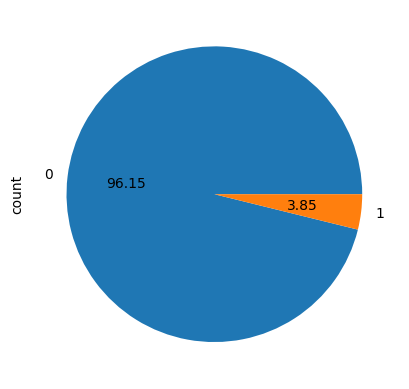

In [137]:
# Plot imbalanced dataset
y.value_counts().plot.pie(autopct='%.2f')
y.value_counts()

In [138]:
# Use oversampling to fix imbalanced dataset
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


In [139]:
# Train model
classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform grid search on the training data
classifier.fit(X_resampled, y_resampled)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [140]:
# Test model performance
y_pred = classifier.predict(X_test)

report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    338493
           1       0.76      0.56      0.64     13485

    accuracy                           0.98    351978
   macro avg       0.87      0.78      0.81    351978
weighted avg       0.97      0.98      0.97    351978



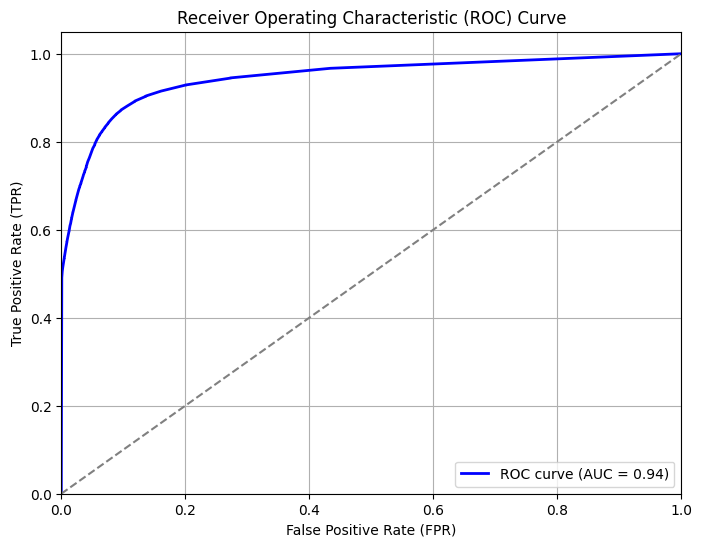

In [141]:
# Plot roc curve 

y_pred_prob = classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [142]:
roc_auc_score(y_test, y_pred_prob)

0.9444277204453706